In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict

load_dotenv()


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)


api = art.UnslothAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="temporal-clue-unsloth-001",
    base_model="unsloth/Qwen2.5-14B-Instruct",
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )

stride = 4
for i in range(await model.get_iteration(), 1_000):
    async with model.openai_client(
        estimated_completion_tokens=900, verbosity=2
    ) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(2))
                    for puzzle in val_puzzles
                ),
                pbar_desc="val",
                stream_chat_completions=8,
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(50))
                    for puzzle in train_puzzles[i * stride : (i + 1) * stride]
                ),
                pbar_desc="train",
            ),
        )
        break
    await model.log(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups,
        config=art.TuneConfig(sequence_length=8192, plot_tensors=True, verbosity=2),
    )

/home/gcpuser/sky_workdir/src/art/unsloth/model.py:3: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth.models import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Started service on localhost:8089 (PID: 67103)


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/200 [00:00<?, ?it/s]

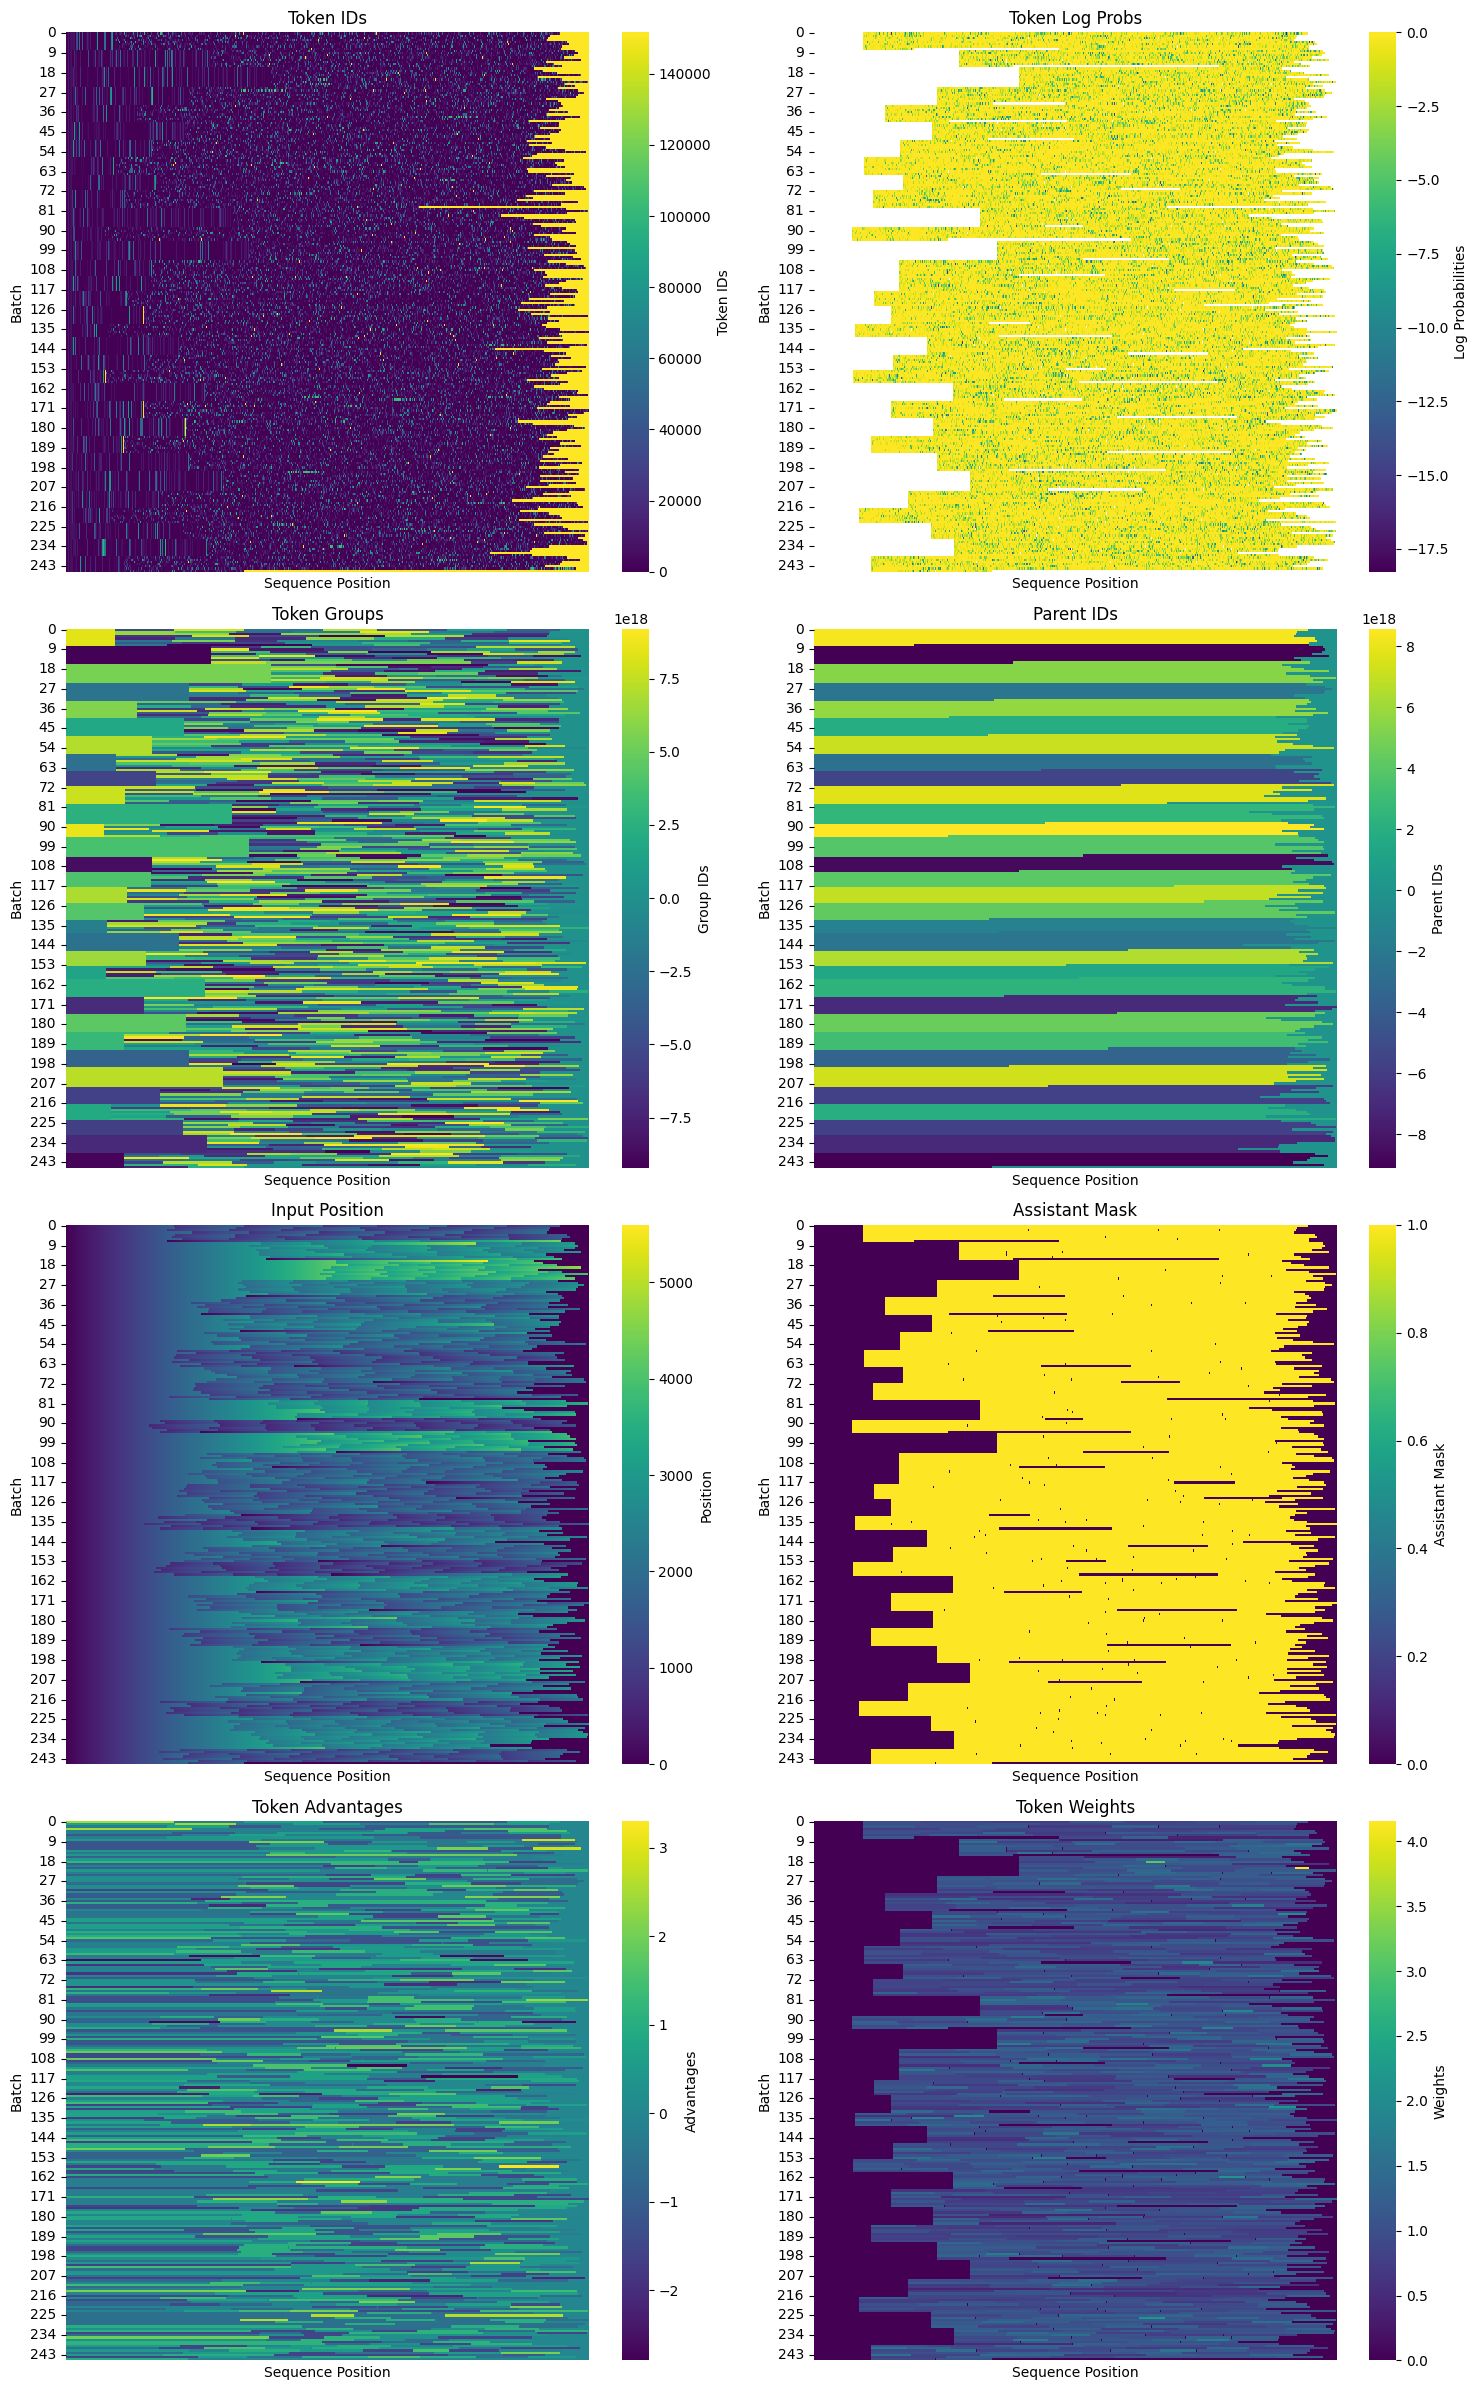

In [ ]:
await model.tune(
        train_groups,
        config=art.TuneConfig(sequence_length=8192, plot_tensors=True, verbosity=2),
    )

In [13]:
# Clean up CUDA memory
import torch
import gc

# Empty CUDA cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

# # If you're using a model, you can move it to CPU to free GPU memory
# if 'model' in locals():
#     model.to('cpu')

# Print memory stats to verify cleanup
print(f"CUDA memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"CUDA memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
print(f"CUDA memory free: {torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# # Optional: Set PyTorch to use expandable segments to avoid fragmentation
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


CUDA memory allocated: 49003.68 MB
CUDA memory reserved: 49362.00 MB
CUDA memory free: 85029109550.00 MB
